# Projet 4: Anticipez les besoins en consommation électrique de bâtiments

- Explication variables 2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m
- Explication variables 2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

Variables à prédire:
- émissions de CO2 => **TotalGHGEmissions**
- consommation totale d’énergie de bâtiments => **SiteEnergyUse(kBtu)**

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et visualisation des datasets](#dataset)
3. [Fusion des 2 datasets](#merge)
4. [Filtre sur les bâtiments non destinés à l'habitation](#filter)
5. [Doublons](#doublons)
7. [Valeurs aberrantes](#outliers)
8. [Valeurs manquantes](#nan)
9. [Analyse exploratoire](#EDA) 
10. [Modèles de prédiction](#predict)
11. [Feature engineering](#features) 

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
import numpy as np
import pandas as pd
from math import *
from P4_functions import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.impute import KNNImputer
from scipy.stats import shapiro # Normalité distribution
from scipy.stats import kruskal

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.tools.eval_measures as ev
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

C:\Users\milie\anaconda3\envs\projet4\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [4]:
# Configuration générale des graphiques
parameters = {'axes.labelsize': 13, 'axes.titlesize': 16, 'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

In [5]:
# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:20,.2f}'.format

In [6]:
#import warnings
#warnings.filterwarnings('ignore')

## Chargement et visualisation des datasets <a class="anchor" id="dataset"></a>

In [7]:
data_2015 = pd.read_csv('data/2015-building-energy-benchmarking.csv', sep = ',', encoding ='utf-8')
data_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.00,88434,0,88434,Hotel,Hotel,"88,434.00",NaN,NaN,NaN,NaN,NaN,65.00,78.90,80.30,173.50,175.10,"6,981,428.00","7,097,539.00","2,023,032.00","1,080,307.00","3,686,160.00","12,724.00","1,272,388.00",0.00,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.00,NaN,31.00,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.00,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,"83,880.00",Parking,"15,064.00",Restaurant,"4,622.00",NaN,51.00,94.40,99.00,191.30,195.20,"8,354,235.00","8,765,788.00",0.00,"1,144,563.00","3,905,411.00","44,490.00","4,448,985.00",0.00,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.00,NaN,31.00,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,1,41.00,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,"757,243.00",Parking,"100,000.00",Swimming Pool,0.00,NaN,18.00,96.60,99.70,242.70,246.50,"73,130,656.00","75,506,272.00","19,660,404.00","14,583,930.00","49,762,435.00","37,099.00","3,709,900.00",0.00,"2,061.48",1.92,Yes,NaN,Compliant,NaN,NaN,56.00,NaN,31.00,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1926,1,10.00,61320,0,61320,Hotel,Hotel,"61,320.00",NaN,NaN,NaN,NaN,NaN,1.00,460.40,462.50,636.30,643.20,"28,229,320.00","28,363,444.00","23,458,518.00","811,521.00","2,769,023.00","20,019.00","2,001,894.00",0.00,"1,936.34",31.38,No,NaN,Compliant,High Outlier,NaN,56.00,NaN,31.00,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98121""}'}",7,DOWNTOWN,1980,1,18.00,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,"123,445.00",Parking,"68,009.00",Swimming Pool,0.00,NaN,67.00,120.10,122.10,228.80,227.10,"14,829,099.00","15,078,243.00",0.00,"1,777,841.00","6,066,245.00","87,631.00","8,763,105.00",0.00,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.00,NaN,31.00,19576


In [8]:
shape_total_nan(data_2015)

Nombre de lignes: 3340
Nombre de colonnes: 47
Nombre total de NaN du dataset: 26512
% total de NaN du dataset: 16.89%


In [9]:
data_2016 = pd.read_csv('data/2016-building-energy-benchmarking.csv', sep = ',', encoding ='utf-8')
data_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,"98,101.00",0659000030,7,DOWNTOWN,47.61,-122.34,1927,1.00,12,88434,0,88434,Hotel,Hotel,"88,434.00",NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,"7,226,362.50","7,456,910.00","2,003,882.00","1,156,514.25","3,946,027.00","12,764.53","1,276,453.00",False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,"98,101.00",0659000220,7,DOWNTOWN,47.61,-122.33,1996,1.00,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,"83,880.00",Parking,"15,064.00",Restaurant,"4,622.00",NaN,61.00,94.80,97.90,176.10,179.40,"8,387,933.00","8,664,479.00",0.00,"950,425.19","3,242,851.00","51,450.82","5,145,082.00",False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,"98,101.00",0659000475,7,DOWNTOWN,47.61,-122.34,1969,1.00,41,956110,196718,759392,Hotel,Hotel,"756,493.00",NaN,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,"72,587,024.00","73,937,112.00","21,566,554.00","14,515,435.00","49,526,664.00","14,938.00","1,493,800.00",False,NaN,Compliant,NaN,"2,089.28",2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,"98,101.00",0659000640,7,DOWNTOWN,47.61,-122.34,1926,1.00,10,61320,0,61320,Hotel,Hotel,"61,320.00",NaN,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,"6,794,584.00","6,946,800.50","2,214,446.25","811,525.31","2,768,924.00","18,112.13","1,811,213.00",False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,"98,121.00",0659000970,7,DOWNTOWN,47.61,-122.34,1980,1.00,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,"123,445.00",Parking,"68,009.00",Swimming Pool,0.00,NaN,75.00,114.80,118.70,211.40,215.60,"14,172,606.00","14,656,503.00",0.00,"1,573,448.62","5,368,607.00","88,039.98","8,803,998.00",False,NaN,Compliant,NaN,505.01,2.88


In [10]:
shape_total_nan(data_2016)

Nombre de lignes: 3376
Nombre de colonnes: 46
Nombre total de NaN du dataset: 19952
% total de NaN du dataset: 12.85%


## Fusion des 2 datasets <a class="anchor" id="merge"></a>

In [11]:
compar_col(data_2015, data_2016)

Colonnes présentes uniquement dans le 1er dataset: 
 {'Seattle Police Department Micro Community Policing Plan Areas', 'GHGEmissions(MetricTonsCO2e)', 'City Council Districts', 'Location', 'Comment', 'OtherFuelUse(kBtu)', 'Zip Codes', 'SPD Beats', 'GHGEmissionsIntensity(kgCO2e/ft2)', '2010 Census Tracts'}
-----------------------------------------------------------------------
Colonnes présentes uniquement dans le 2ème dataset: 
 {'Address', 'City', 'ZipCode', 'TotalGHGEmissions', 'Latitude', 'GHGEmissionsIntensity', 'Comments', 'Longitude', 'State'}


Avant de fusionner les 2 datasets, nous allons:
- renommer les variables identiques
- créer de nouvelles variables lorsque l'information est présente dans une seule colonne (cf colonne Location)
- supprimer les variables présentes sur 2015 mais non reprises sur 2016

Nous vérifierons ensuite que les champs des variables catégorielles sont bien harmonisés entre 2015 et 2016 et filtrerons le dataset sur les bâtiments non résidentiels.

### Renommage des variables identiques

In [12]:
# On renomme les colonnes identiques
data_2015.rename(columns={'Comment': 'Comments', 
                          'Zip Codes': 'ZipCode',
                          'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                          'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'}, inplace = True)

### Création de nouvelles variables

In [13]:
# Données présentes dans la colonne Location de data_2015
data_2015['Location']

0         {'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
1           {'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{"address": "724 PINE ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
2          {'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{"address": "1900 5TH AVE", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
3        {'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{"address": "620 STEWART ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
4           {'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{"address": "401 LENORA ST", "city": "SEATTLE", "state": "WA", "zip": "98121"}'}
                                                                                     ...                                                                             

In [14]:
# Création de nouvelles variables
data_2015['Latitude'] = data_2015['Location'].apply(lambda x: eval(x)['latitude']).astype('float64')
data_2015['Longitude'] = data_2015['Location'].apply(lambda x: eval(x)['longitude']).astype('float64')
data_2015['Human_address'] = data_2015['Location'].apply(lambda x: eval(x)['human_address']).astype('str')
data_2015['Address'] = data_2015['Human_address'].apply(lambda x: eval(x)['address']).astype('str')
data_2015['City'] = data_2015['Human_address'].apply(lambda x: eval(x)['city']).astype('str')
data_2015['State'] = data_2015['Human_address'].apply(lambda x: eval(x)['state']).astype('str')
data_2015['ZipCode'] = data_2015['Human_address'].apply(lambda x: eval(x)['zip']).astype('int32')

In [15]:
# Suppression des variables non nécessaires qui nous ont permis d'extraire les données
data_2015.drop(columns=['Location', 'Human_address'], inplace = True)

In [16]:
data_2015[['Latitude', 'Longitude', 'Address', 'City', 'State', 'ZipCode']].head()

,Latitude,Longitude,Address,City,State,ZipCode
0,47.61,-122.34,405 OLIVE WAY,SEATTLE,WA,98101
1,47.61,-122.33,724 PINE ST,SEATTLE,WA,98101
2,47.61,-122.34,1900 5TH AVE,SEATTLE,WA,98101
3,47.61,-122.34,620 STEWART ST,SEATTLE,WA,98101
4,47.61,-122.34,401 LENORA ST,SEATTLE,WA,98121


### Suppression des variables présentes sur 2015 uniquement

In [17]:
data_2015.drop(columns=['SPD Beats', '2010 Census Tracts', 'City Council Districts', 'OtherFuelUse(kBtu)',
                       'Seattle Police Department Micro Community Policing Plan Areas'], inplace = True)

### Fusion des 2 datasets

In [18]:
# Vérification que les datasets contiennent les mêmes colonnes
compar_col(data_2015, data_2016)

Colonnes présentes uniquement dans le 1er dataset: 
 set()
-----------------------------------------------------------------------
Colonnes présentes uniquement dans le 2ème dataset: 
 set()


In [19]:
data = pd.concat([data_2015, data_2016]).sort_values('OSEBuildingID')

In [20]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,ZipCode,Latitude,Longitude,Address,City,State
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.00,12.00,88434,0,88434,Hotel,Hotel,"88,434.00",NaN,NaN,NaN,NaN,NaN,65.00,78.90,80.30,173.50,175.10,"6,981,428.00","7,097,539.00","2,023,032.00","1,080,307.00","3,686,160.00","12,724.00","1,272,388.00",249.43,2.64,No,NaN,Compliant,NaN,"98,101.00",47.61,-122.34,405 OLIVE WAY,SEATTLE,WA
0,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.00,12.00,88434,0,88434,Hotel,Hotel,"88,434.00",NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,"7,226,362.50","7,456,910.00","2,003,882.00","1,156,514.25","3,946,027.00","12,764.53","1,276,453.00",249.98,2.83,False,NaN,Compliant,NaN,"98,101.00",47.61,-122.34,405 Olive way,Seattle,WA
1,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.00,11.00,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,"83,880.00",Parking,"15,064.00",Restaurant,"4,622.00",NaN,61.00,94.80,97.90,176.10,179.40,"8,387,933.00","8,664,479.00",0.00,"950,425.19","3,242,851.00","51,450.82","5,145,082.00",295.86,2.86,False,NaN,Compliant,NaN,"98,101.00",47.61,-122.33,724 Pine street,Seattle,WA
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.00,11.00,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,"83,880.00",Parking,"15,064.00",Restaurant,"4,622.00",NaN,51.00,94.40,99.00,191.30,195.20,"8,354,235.00","8,765,788.00",0.00,"1,144,563.00","3,905,411.00","44,490.00","4,448,985.00",263.51,2.38,No,NaN,Compliant,NaN,"98,101.00",47.61,-122.33,724 PINE ST,SEATTLE,WA
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.00,41.00,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,"757,243.00",Parking,"100,000.00",Swimming Pool,0.00,NaN,18.00,96.60,99.70,242.70,246.50,"73,130,656.00","75,506,272.00","19,660,404.00","14,583,930.00","49,762,435.00","37,099.00","3,709,900.00","2,061.48",1.92,Yes,NaN,Compliant,NaN,"98,101.00",47.61,-122.34,1900 5TH AVE,SEATTLE,WA


In [21]:
shape_total_nan(data)

Nombre de lignes: 6716
Nombre de colonnes: 46
Nombre total de NaN du dataset: 40207
% total de NaN du dataset: 13.01%


###  Harmonisation des champs des variables catégorielles

####  Description des variables

<div class="alert alert-block alert-info">
    <p> Future warning, comment transformer la fonction? </p>
</div>

In [22]:
describe_variables_light(data.iloc[:, data.columns.isin(data.select_dtypes(include = 'object').columns)])

C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_funct

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,BuildingType,object,NonResidential,6716,8,0.12,6716,100.00,0,0.00
1,PrimaryPropertyType,object,Hotel,6716,32,0.48,6716,100.00,0,0.00
2,PropertyName,object,MAYFLOWER PARK HOTEL,6716,6527,97.19,6716,100.00,0,0.00
3,TaxParcelIdentificationNumber,object,659000030,6716,3729,55.52,6714,99.97,2,0.03
4,Neighborhood,object,DOWNTOWN,6716,19,0.28,6716,100.00,0,0.00
5,ListOfAllPropertyUseTypes,object,Hotel,6716,488,7.27,6580,97.97,136,2.03
6,LargestPropertyUseType,object,Hotel,6716,57,0.85,6560,97.68,156,2.32
7,SecondLargestPropertyUseType,object,Parking,6716,50,0.74,3238,48.21,3478,51.79
8,ThirdLargestPropertyUseType,object,Restaurant,6716,45,0.67,1156,17.21,5560,82.79
9,YearsENERGYSTARCertified,object,2016,6716,116,1.73,229,3.41,6487,96.59


C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_funct

C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_funct

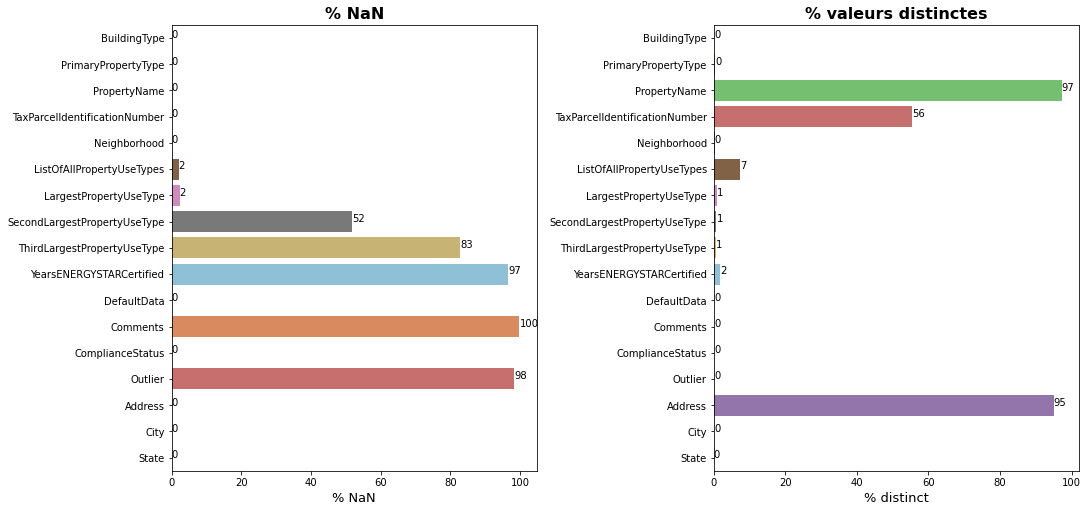

In [23]:
completion_distinct_plots(data.iloc[:, data.columns.isin(data.select_dtypes(include = 'object').columns)])

####  Modalités des variables

In [24]:
# Différentes modalités des variables catégorielles sélectionnées

liste_col_categ = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'DefaultData', 'ComplianceStatus', 
                   'Outlier', 'City','State']

print('Modalités des colonnes:')
for column in liste_col_categ:
    #data[column] = data[column].astype(str)
    data[column] = data[column].str.title()
    print()
    print(f"***{column}***")
    print(data[column].value_counts())
    #print(sorted(data[column].unique())[0:60])
    print("--------------------------------------------------------------")

Modalités des colonnes:

***BuildingType***
Nonresidential          2921
Multifamily Lr (1-4)    2047
Multifamily Mr (5-9)    1134
Multifamily Hr (10+)     217
Sps-District K-12        197
Nonresidential Cos       153
Campus                    46
Nonresidential Wa          1
Name: BuildingType, dtype: int64
--------------------------------------------------------------

***PrimaryPropertyType***
Low-Rise Multifamily           1985
Mid-Rise Multifamily           1103
Small- And Mid-Sized Office     590
Other                           514
Large Office                    344
K-12 School                     275
Mixed Use Property              259
High-Rise Multifamily           208
Retail Store                    191
Non-Refrigerated Warehouse      187
Warehouse                       187
Hotel                           150
Worship Facility                143
Senior Care Community            88
Medical Office                   82
Distribution Center              55
Distribution Center\n    

In [25]:
# Harmonisation des modalités de BuildingType
data.loc[data['BuildingType'] == 'Nonresidential Wa', 'BuildingType'] = 'Nonresidential'

In [26]:
# Harmonisation des modalités de PrimaryPropertyType
data.loc[data['PrimaryPropertyType'] == 'Self-Storage Facility\n', 'PrimaryPropertyType'] = 'Self-Storage Facility'
data.loc[data['PrimaryPropertyType'] == 'Distribution Center\n', 'PrimaryPropertyType'] = 'Distribution Center'
data.loc[data['PrimaryPropertyType'] == 'Supermarket / Grocery Store', 'PrimaryPropertyType'] = 'Supermarket/Grocery Store'
data.loc[data['PrimaryPropertyType'] == 'Restaurant\n', 'PrimaryPropertyType'] = 'Restaurant'
data.loc[data['PrimaryPropertyType'] == 'Residence Hall/Dormitory', 'PrimaryPropertyType'] = 'Residence Hall'
data.loc[data['PrimaryPropertyType'] == 'University', 'PrimaryPropertyType'] = 'College/University'
data.loc[data['PrimaryPropertyType'] == 'Sps-District K-12', 'PrimaryPropertyType'] = 'K-12 School'

In [27]:
# Harmonisation des modalités de Neighborhood
data.loc[data['Neighborhood'] == 'Delridge Neighborhoods', 'Neighborhood'] = 'Delridge'

In [28]:
# Amélioration des modalités de la colonne YearsENERGYSTARCertified
def split_years(x):
    x_str = str(x).replace('nan', '')
    if ',' in x_str:
        years = [i.strip() for i in str(x_str).split(',')]
    elif len(x_str)%4==0:
        #years = [x_str[4*(i):4*(i+1)] for i in range(int(len(x_str)/4))]
        years = [x_str[i:i+4] for i in range(0, len(x_str), 4)]
    else:
        years = x_str
    return tuple(years)

data['YearsENERGYSTARCertified'] = data['YearsENERGYSTARCertified'].apply(lambda x: split_years(x))

#data['YearsENERGYSTARCertified'].fillna('Not Certified', inplace = True)

In [29]:
# Suppression de la variable Comments, State et City
data.drop(['Comments', 'State', 'City'], axis = 'columns', inplace = True)

In [30]:
# Harmonisation des modalités de ComplianceStatus
data.loc[data['ComplianceStatus'] == 'Not Compliant', 'ComplianceStatus'] = 'Non-Compliant'

####  Complétion des variables catégorielles en fonction de l'ID du bâtiment

<div class="alert alert-block alert-info">
    <p> name 'np' is not defined quand fonction dans P4_funtions.py </p>
</div>

In [31]:
def mapping(dataframe, var_to_map, var_mapping):
    table_mapping = dataframe.groupby([var_mapping, var_to_map])['DataYear'].count().reset_index()
    table_mapping = table_mapping.sort_values(var_to_map, ascending = True) # sur col txt
    table_mapping = table_mapping.drop_duplicates(subset = var_mapping, keep = 'first') # first car nan after
    
    # Merge du dataframe avec la table de mapping
    df = pd.merge(left = dataframe, right = table_mapping[[var_mapping, var_to_map]], 
                  how = "left", on = var_mapping)
    
    # Lorsque la var_to_map est NaN, je complète avec la valeur du mapping
    df[f'{var_to_map}_x'] = np.where(df[f'{var_to_map}_x'].isnull(), 
                                     df[f'{var_to_map}_y'], 
                                     df[f'{var_to_map}_x'])
    
    # On supprime la variable issue de la jointure et on enlève le suffixe _x
    df.rename(columns={f'{var_to_map}_x': var_to_map}, inplace = True)
    df.drop(f'{var_to_map}_y', axis = 'columns', inplace = True)
    
    return df

In [32]:
# Mapping de ListOfAllPropertyUseTypes
print(f"% NaN après mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'ListOfAllPropertyUseTypes', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN après mapping: 2.32 %
% NaN après mapping: 2.32 %


In [33]:
# Mapping de LargestPropertyUseType
print(f"% NaN avant mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'LargestPropertyUseType', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN avant mapping: 2.32 %
% NaN après mapping: 0.61 %


In [34]:
# Mapping de SecondLargestPropertyUseType
print(f"% NaN avant mapping: {round(data['SecondLargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'SecondLargestPropertyUseType', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['SecondLargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN avant mapping: 51.790000000000006 %
% NaN après mapping: 50.33 %


In [35]:
# Mapping de ThirdLargestPropertyUseType
print(f"% NaN avant mapping: {round(data['ThirdLargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'ThirdLargestPropertyUseType', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['ThirdLargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN avant mapping: 82.78999999999999 %
% NaN après mapping: 82.3 %


In [36]:
# Mapping de TaxParcelIdentificationNumber
print(f"% NaN avant mapping: {round(data['TaxParcelIdentificationNumber'].isna().mean(),4)*100} %")
data = mapping(data, 'TaxParcelIdentificationNumber', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['TaxParcelIdentificationNumber'].isna().mean(),4)*100} %")

% NaN avant mapping: 0.03 %
% NaN après mapping: 0.01 %


In [37]:
# Mapping de DefaultData
print(f"% NaN avant mapping: {round(data['DefaultData'].isna().mean(),4)*100} %")
data = mapping(data, 'DefaultData', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['DefaultData'].isna().mean(),4)*100} %")

% NaN avant mapping: 50.28 %
% NaN après mapping: 1.4000000000000001 %


In [38]:
# Mapping de Outlier
print(f"% NaN avant mapping: {round(data['Outlier'].isna().mean(),4)*100} %")
data = mapping(data, 'Outlier', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['Outlier'].isna().mean(),4)*100} %")

% NaN avant mapping: 98.27 %
% NaN après mapping: 97.19 %


## Filtre sur les bâtiments non destinés à l'habitation <a class="anchor" id="filter"></a>

Nous nous intéressons aux émissions des bâtiments **non destinés à l’habitation**. Nous allons donc filtrer le dataset sur les bâtiments non résidentiels. Pour ce faire, nous nous baserons sur le champ **PrimaryPropertyType** qui correspond à l'utilisation principale (+ de 50%) d'une propriété. Ce champ a l'avantage d'être plus détaillé que le BuildingType et se base sur l'utilisation principale du bâtiment alors que le champ LargestPropertyUseType est basé sur sa superficie.

In [39]:
data_gpby_type = data.groupby(['PrimaryPropertyType', 'LargestPropertyUseType'])['OSEBuildingID'].count()
data_gpby_type

PrimaryPropertyType          LargestPropertyUseType                              
College/University           College/University                                        46
                             Office                                                     1
Distribution Center          Distribution Center                                      105
                             Non-Refrigerated Warehouse                                 1
High-Rise Multifamily        Multifamily Housing                                      206
Hospital                     Hospital (General Medical & Surgical)                     20
Hotel                        Hotel                                                    149
K-12 School                  K-12 School                                              279
Laboratory                   Laboratory                                                11
Large Office                 Office                                                   344
Low-Rise Multifami

In [40]:
# Filtre sur les bâtiments non destinés à l'habitation
PrimaryPropertyType_to_delete = ['High-Rise Multifamily','Low-Rise Multifamily', 'Mid-Rise Multifamily']
data = data[~data['PrimaryPropertyType'].isin(PrimaryPropertyType_to_delete)]

In [41]:
shape_total_nan(data)

Nombre de lignes: 3420
Nombre de colonnes: 43
Nombre total de NaN du dataset: 13468
% total de NaN du dataset: 9.16%


## Doublons <a class="anchor" id="doublons"></a>

Lorsque plusieurs **OSEBuildingID** sont identiques, nous conserverons la ligne de celui contenant le **moins de valeurs manquantes**. Il est important de n'avoir que des OSEBuildingID uniques lorsque nous séparerons le dataset en données d'entrainement et de test afin de ne pas prédire la consommation d'un bâtiment qui aurait déjà été vu par notre algorithme.

In [42]:
# Nombre de doublons sur la colonne OSEBuildingID
print(f"Codes en doublons: {data.duplicated('OSEBuildingID').sum()}")

Codes en doublons: 1669


In [43]:
# Supprimons les lignes dupliquées qui ont le plus grand nombre de NaN
data['null_count'] = data.isnull().sum(1)

data = data.sort_values('null_count')\
       .drop_duplicates(subset = "OSEBuildingID")\
       .sort_index()

In [44]:
# Suppression de la variable null_count
data.drop('null_count', axis='columns', inplace = True)

In [45]:
shape_total_nan(data)

Nombre de lignes: 1751
Nombre de colonnes: 43
Nombre total de NaN du dataset: 6813
% total de NaN du dataset: 9.05%


In [46]:
#data.to_excel("data_cleaned.xlsx") 

## Valeurs aberrantes <a class="anchor" id="outliers"></a>

Nous allons vérifier la cohérence de certaines variables qui peuvent être recalculées:
- la **quantité annuelle d'énergie consommée par la propriété**, toutes sources d'énergie confondues (SiteEnergyUse(kBtu)) ne peut être égale ou inférieure à 0
- la **quantité annuelle de CO2 consommé par la propriété** (TotalGHGEmissions) ne peut être égale ou inférieure à 0
- le **nombre de bâtiments** ne peut être inférieur ou égal à 0
- la **somme de toutes les sources d'énergie** (vapeur, électricité, gaz naturel) doit être proche de la valeur de la variable SiteEnergyUse(kBtu)
- la **surface des bâtiments + parkings** (PropertyGFATotal) est bien égale à la surface des bâtiments (PropertyGFABuilding(s)) et du parking (PropertyGFAParking)
- la **surface des bâtiments la plus importante** (LargestPropertyUseTypeGFA) ne peut être supérieure à la surface des bâtiments + parkings (PropertyGFATotal)

In [47]:
# SiteEnergyUse(kBtu) strictement supérieur à 0
print(f"Nb de lignes à supprimer: {data[data['SiteEnergyUse(kBtu)'] <= 0].shape[0]}")
data = data[data['SiteEnergyUse(kBtu)'] > 0]

Nb de lignes à supprimer: 4


In [48]:
# TotalGHGEmissions strictement supérieur à 0
print(f"Nb de lignes à supprimer: {data[data['TotalGHGEmissions'] <= 0].shape[0]}")
data = data[data['TotalGHGEmissions'] > 0]

Nb de lignes à supprimer: 1


In [49]:
# NumberofBuildings strictement supérieur à 0
print(f"Nb de lignes à supprimer: {data[data['NumberofBuildings'] <= 0].shape[0]}")
data = data[data['NumberofBuildings'] > 0]

Nb de lignes à supprimer: 24


In [50]:
# Somme des sources d'énergie proches de SiteEnergyUse(kBtu) (plus ou moins 10%)
energy_cols = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']


data['energy_sum'] = data[energy_cols].sum(axis='columns')
energy_sum_sup_10_percent = ~data['energy_sum'].between(data['SiteEnergyUse(kBtu)']*0.9,
                                                        data['SiteEnergyUse(kBtu)']*1.1)
print(f"Nb de lignes à supprimer: {data[energy_sum_sup_10_percent].shape[0]}")

data = data[~energy_sum_sup_10_percent]
data.drop('energy_sum', axis='columns', inplace = True)

Nb de lignes à supprimer: 8


In [51]:
# Surface PropertyGFATotal = PropertyGFABuilding(s) + PropertyGFAParking
print(f"Nb de lignes à supprimer: {data[~data['PropertyGFATotal'] == data['PropertyGFABuilding(s)'] + data['PropertyGFAParking']].shape[0]}")

Nb de lignes à supprimer: 0


In [52]:
# Surface LargestPropertyUseTypeGFA <= PropertyGFATotal
print(f"Nb de lignes à supprimer: {data[data['LargestPropertyUseTypeGFA'] > data['PropertyGFATotal']].shape[0]}")
data = data[data['LargestPropertyUseTypeGFA'] <= data['PropertyGFATotal']]

Nb de lignes à supprimer: 217


In [53]:
shape_total_nan(data)

Nombre de lignes: 1483
Nombre de colonnes: 43
Nombre total de NaN du dataset: 5564
% total de NaN du dataset: 8.73%


## Valeurs manquantes <a class="anchor" id="nan"></a>

In [80]:
# Copie du dataset
data_clean = data.copy()

Nous allons imputer les valeurs manquantes de différentes manières:

- **suppression des variables DefaultData** et **ZipCode** qui ne nous apporte pas de complément d'information
- **constante 'Not an Outlier"** pour la variable Outlier
- pour les variables sur le **type des bâtiments** (SecondLargestPropertyUseType et ThirdLargestPropertyUseType), nous imputerons les valeurs manquantes par la **constante 'None'** car il s'agit de bâtiments n'ayant qu'un usage principal ou secondaire. Nous remplirons donc les variables associées sur la superficie par 0
- **K Nearest Neighboors** pour les variables **ZipCode** et **ENERGYSTARScore**

In [81]:
print('Taux de remplissage:')
not_nan_percent = round(data_clean.notna().mean().sort_values(ascending = False),4)*100
not_nan_percent[not_nan_percent < 100]

Taux de remplissage:


ZipCode                                          98.92
DefaultData                                      97.24
ENERGYSTARScore                                  67.70
SecondLargestPropertyUseType                     55.16
SecondLargestPropertyUseTypeGFA                  55.16
ThirdLargestPropertyUseTypeGFA                   24.14
ThirdLargestPropertyUseType                      24.14
Outlier                                           2.36
dtype: float64

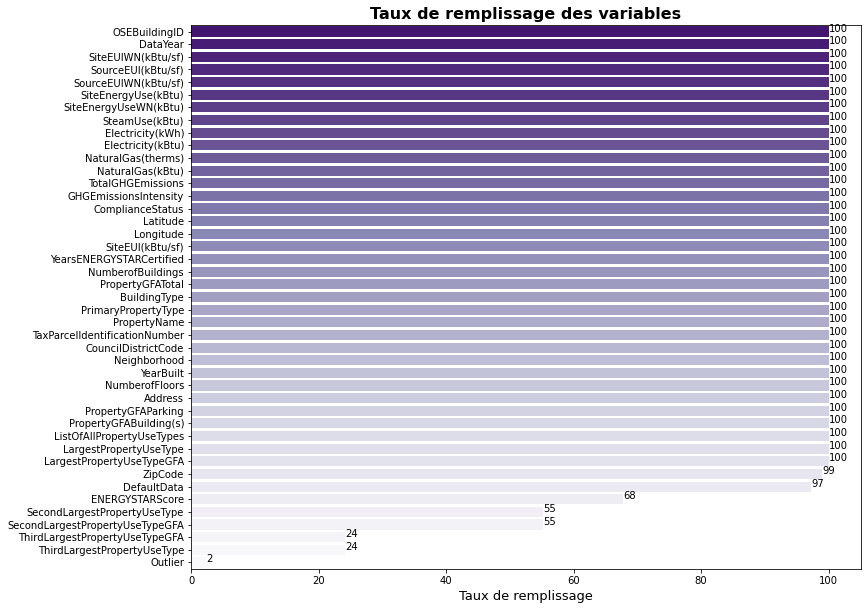

In [82]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(y = not_nan_percent.index, x = not_nan_percent.values, palette = 'Purples_r')
plt.title("Taux de remplissage des variables")
plt.ylabel("")
plt.xlabel("Taux de remplissage")
etiquette_h(ax)
# plt.axvline(x = 20, color = 'r');
#plt.text(42, -1, '>40%', color='r');

In [83]:
# Suppression des variables DefaultData et ZipCode
data_clean = data_clean.drop(['DefaultData', 'ZipCode'], axis = 'columns', inplace = False)

In [84]:
# Imputation de la variable 'Outlier' par la constante 'Not an Outlier'
data_clean['Outlier'] = data_clean['Outlier'].fillna('Not an Outlier')

In [85]:
# Imputation des variables SecondLargestPropertyUseType et ThirdLargestPropertyUseType par la constante None
data_clean[['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']] = data_clean[['SecondLargestPropertyUseType', 
                                                                                          'ThirdLargestPropertyUseType']].fillna('None')

In [86]:
# Imputation des variables SecondLargestPropertyUseTypeGFA et ThirdLargestPropertyUseTypeGFA par la constante 0
data_clean[['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = data_clean[['SecondLargestPropertyUseTypeGFA', 
                                                                                          'ThirdLargestPropertyUseTypeGFA']].fillna(0)

Nous ne remplaçons par les valeurs manquantes de la variable ENERGYSTARScore car si l'on regarde sa définition, il semblerait que ce soit un leak, c'est à dire une variable très corrélée à la variable target et qui doit être supprimée. Nous vérifierons notre hypothèse dans la partie sur l'analyse exploratoire.

In [87]:
shape_total_nan(data_clean)

Nombre de lignes: 1483
Nombre de colonnes: 41
Nombre total de NaN du dataset: 479
% total de NaN du dataset: 0.79%


## Analyse exploratoire <a class="anchor" id="EDA"></a>

### Description des variables

In [88]:
describe_variables(data_clean)

C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_function

C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_function

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,OSEBuildingID,int64,1,1483,1483,100.00,1483,100.00,0,0.00,,,,,,,,,,
1,DataYear,int64,2015,1483,2,0.13,1483,100.00,0,0.00,,,,,,,,,,
2,BuildingType,object,Nonresidential,1483,7,0.47,1483,100.00,0,0.00,,,,,,,,,,
3,PrimaryPropertyType,object,Hotel,1483,22,1.48,1483,100.00,0,0.00,,,,,,,,,,
4,PropertyName,object,MAYFLOWER PARK HOTEL,1483,1467,98.92,1483,100.00,0,0.00,,,,,,,,,,
5,TaxParcelIdentificationNumber,object,659000030,1483,1431,96.49,1483,100.00,0,0.00,,,,,,,,,,
6,CouncilDistrictCode,int64,7,1483,7,0.47,1483,100.00,0,0.00,,,,,,,,,,
7,Neighborhood,object,Downtown,1483,13,0.88,1483,100.00,0,0.00,,,,,,,,,,
8,YearBuilt,int64,1927,1483,113,7.62,1483,100.00,0,0.00,,,,,,,,,,
9,NumberofBuildings,float64,1.00,1483,12,0.81,1483,100.00,0,0.00,1.10,1.00,21.71,562.09,1.68,1.29,1.00,1.00,1.00,39.00


### Analyse univariée

La prédiction se basant sur les **données déclaratives du permis d'exploitation commerciale** (taille et usage des bâtiments, mention de travaux récents, date de construction...) et l'objectif étant de **se passer des relevés de consommation annuels**, certaines variables telles que 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', , 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)','NaturalGas(kBtu)' et 'GHGEmissionsIntensity' seront écartées de notre dataset. Nous allons cependant créer une variable plus générale sur le **type d'énergie principal** utilisé. De plus certaines variables comme Electricity(kBtu) étaient très fortement corrélées à nos targets et présentaient un gros risque de data leakage.

In [89]:
# Steam
data_clean['Steam%'] = ((data_clean['SteamUse(kBtu)']/data_clean['SiteEnergyUse(kBtu)'])*100).apply(ceil)

# Electricity
data_clean['Electricity%'] = ((data_clean['Electricity(kBtu)']/data_clean['SiteEnergyUse(kBtu)'])*100).apply(ceil)

# Natural Gas
data_clean['Gas%'] = ((data_clean['NaturalGas(kBtu)']/data_clean['SiteEnergyUse(kBtu)'])*100).apply(ceil)

In [90]:
data_clean[['OSEBuildingID','Steam%', 'Electricity%', 'Gas%']].head()

,OSEBuildingID,Steam%,Electricity%,Gas%
0,1,29,53,19
2,2,0,39,62
4,3,27,69,6
7,5,33,41,27
8,8,0,38,63


In [91]:
# Création variable indiquant le type d'énergie principal
data_clean['MainEnergyUsed'] = data_clean[['Steam%', 'Electricity%', 'Gas%']].idxmax(axis = 1)
data_clean['MainEnergyUsed'] = data_clean['MainEnergyUsed'].replace('\%','',regex=True).astype(object)

In [92]:
# Dataset réduit des features
data_clean = data_clean[['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 
                         'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 
                         'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 
                         'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 
                         'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 
                         'ENERGYSTARScore', 'ComplianceStatus', 'Outlier', 'MainEnergyUsed', 
                         'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]

#### Variables quantitatives

**Variables indépendantes**

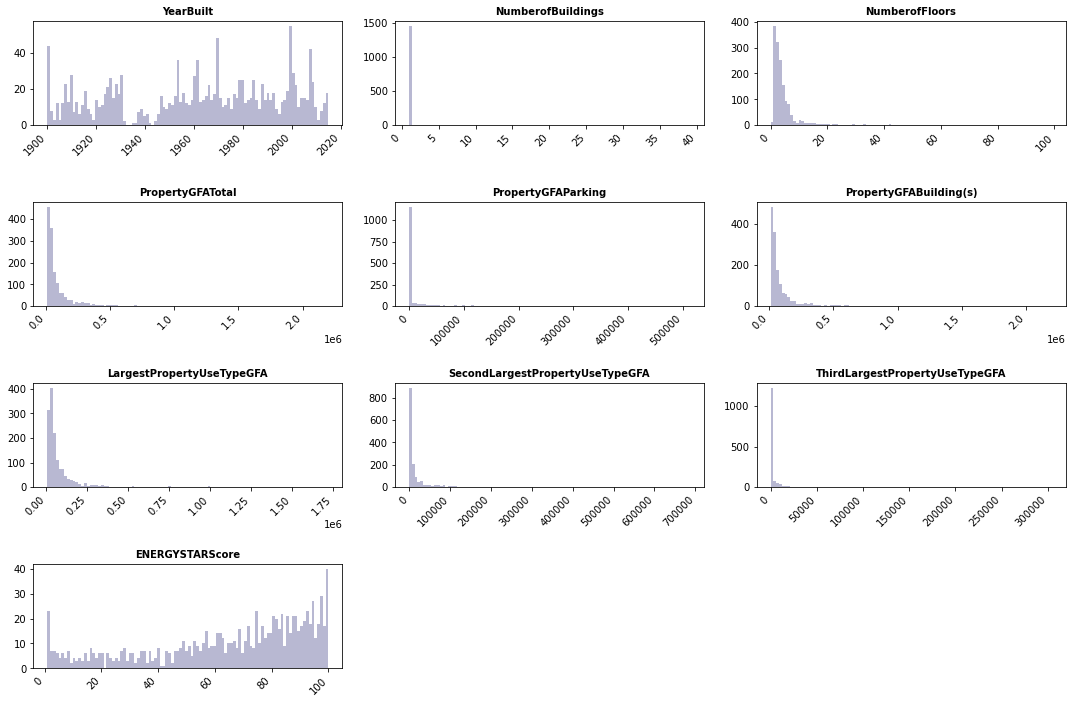

In [111]:
col_quanti = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 
              'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 
              'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore']

fig = plt.figure(figsize=(15,12))
univariate_plots_hist(data_clean, col_quanti, 5, 3, 100)

<div class="alert alert-block alert-warning">
    <p> La plupart des distributions exceptées celles des variables YearBuilt et ENERGYSTARScore ont une apparence similaire avec un pic sur les valeurs inférieures. </p>
    <p> Elles sont étalées vers la droite et auront besoin d'être standardisées pour être mises à la même échelle. En effet, on remarque en particulier que ces variables prennent des valeurs dans des ensembles différents. Par exemple, “NumberofFloors” varie de 0 à 100 tandis que “PropertyGFAParking” varie de 0 à plus de 500 000. Il va donc nous falloir standardiser les données pour que la deuxième ne domine pas complètement la première.</p>
</div>

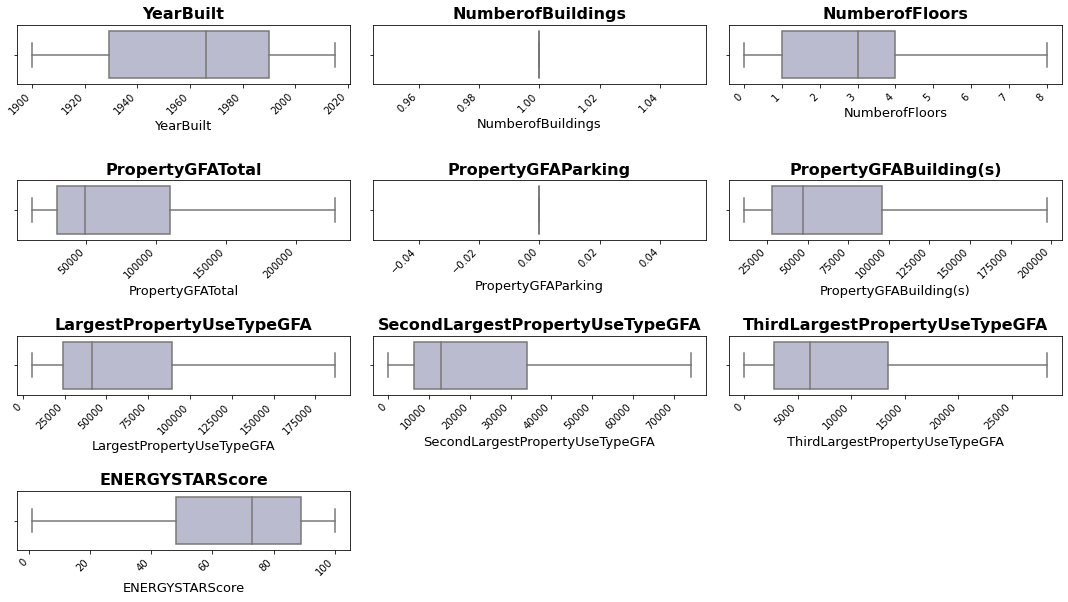

In [112]:
fig = plt.figure(figsize=(15,10))
univariate_plots_box(data_clean, col_quanti, 5, 3)

In [113]:
print('Test de Shapiro-Wilk: ')
print()
for c in col_quanti:     
    print(f'Variable {c}: {test_normalite(data_clean[c])}')

Test de Shapiro-Wilk: 

Variable YearBuilt: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable NumberofBuildings: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable NumberofFloors: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable PropertyGFATotal: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable PropertyGFAParking: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable PropertyGFABuilding(s): On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable LargestPropertyUseTypeGFA: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable SecondLargestPropertyUseTypeGFA: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable ThirdLargestPropertyUseTypeGFA: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable ENERGYSTARScore: On accepte H0, distribution Normale (pvalue = 1.0 > 0.05)


<div class="alert alert-block alert-warning">
    <p> Le test de Shapiro_Wilk rejette l'hypothèse nulle selon laquelle les échantillons suivent une distribution Normale. </p>
    <p> L'hypothèse nulle n'est pas rejetée pour la variable ENERGYSTARScore. </p>
</div>

**Variables Targets**

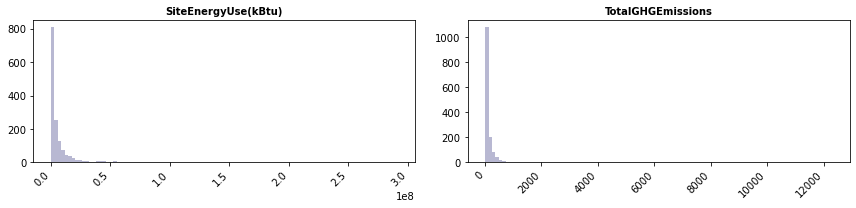

In [105]:
col_target = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

fig = plt.figure(figsize=(12,3))
univariate_plots_hist(data_clean, col_target, 1, 2, 100)

<div class="alert alert-block alert-warning">
    <p> Ces deux distributions ont une apparence similaire avec de nombreuses observations sur les valeurs les plus faibles. </p>
    <p> Lorsque les distributions sont regroupées sur les valeurs les plus faibles et peu étalées la transformation log est le plus souvent utilisée.</p>
</div>

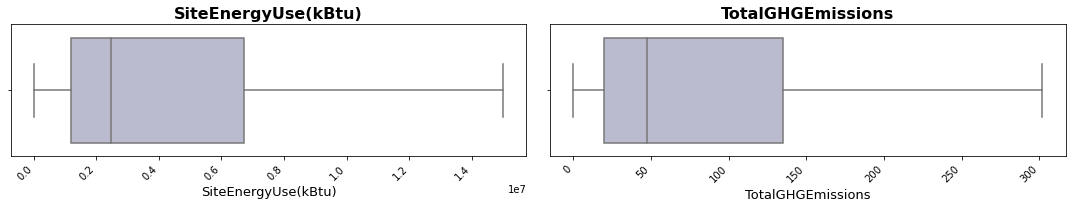

In [106]:
fig = plt.figure(figsize=(15,3))
univariate_plots_box(data_clean, col_target, 1, 2)

In [107]:
print('Test de Shapiro-Wilk: ')
print()
for c in col_target:     
    print(f'Variable {c}: {test_normalite(data_clean[c])}')

Test de Shapiro-Wilk: 

Variable SiteEnergyUse(kBtu): On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)
Variable TotalGHGEmissions: On rejette H0, distribution non Normale (pvalue = 0.0 < 0.05)


<div class="alert alert-block alert-warning">
    <p> Le test de Shapiro_Wilk rejette l'hypothèse nulle selon laquelle les variables target suivent une distribution Normale. </p>
    <p> Il faudra les transformer pour que les distributions se rapprochent le plus de distributions Normales. </p>
</div>

In [108]:
# Création des variables target transformées en log
data_clean['SiteEnergyUse(kBtu)_log'] = np.log(data_clean['SiteEnergyUse(kBtu)'])
data_clean['TotalGHGEmissions_log'] = np.log(data_clean['TotalGHGEmissions'])

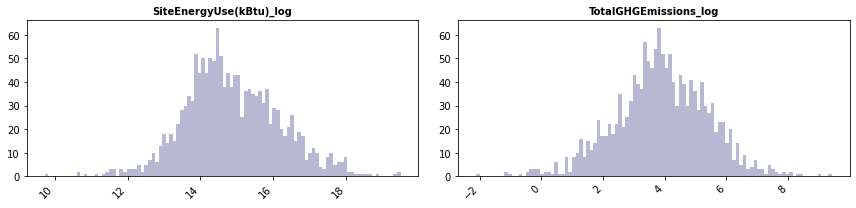

In [109]:
col_target_log = ['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log']

fig = plt.figure(figsize=(12,3))
univariate_plots_hist(data_clean, col_target_log, 1, 2, 100)

La transformation des targets en log rend bien leur distribution proche d'une Loi Normale.

#### Variables qualitatives

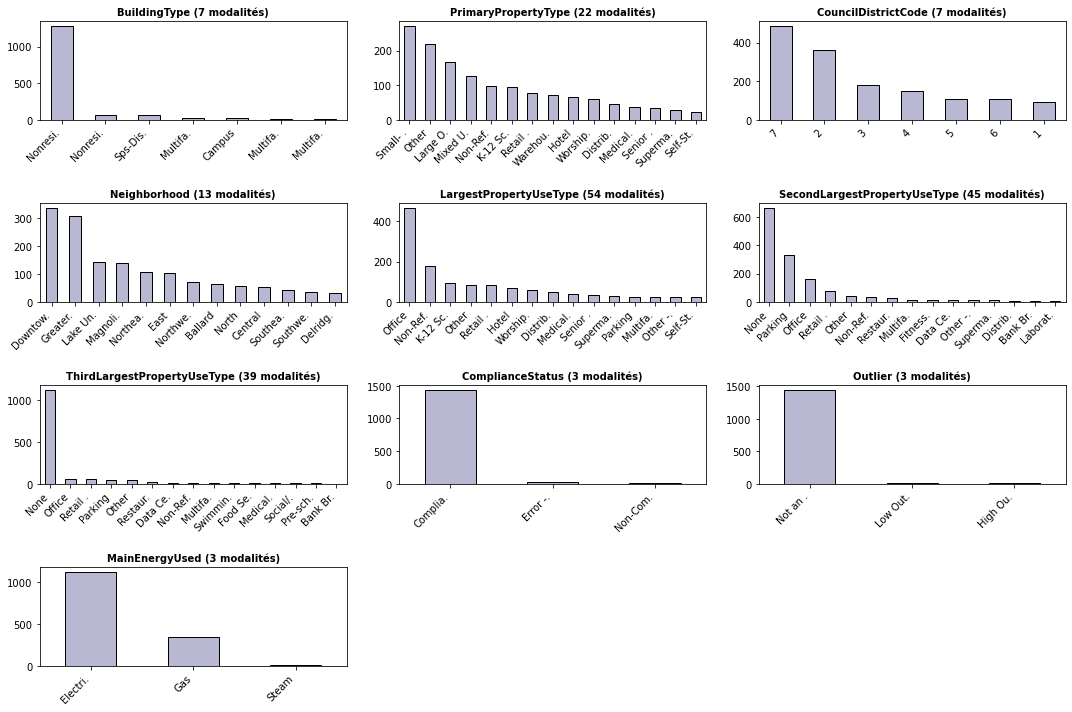

In [119]:
col_quali = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType', 
            'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'ComplianceStatus','Outlier', 'MainEnergyUsed']

fig = plt.figure(figsize=(15,10))
univariate_plots_quali(data_clean, col_quali, 4, 3)

### Analyse bivariée / multivariée

#### Entre variables quantitatives

**Corrélations avec les targets**

In [120]:
liste_var = col_quanti + col_target

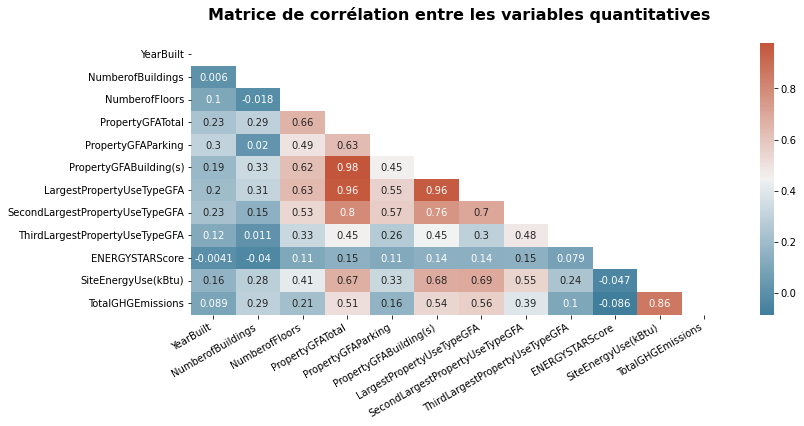

In [121]:
# Corrélation
corr = data_clean[liste_var].corr()

# Création d'un masque
mask = np.triu(corr)

# Taille du graph
plt.subplots(figsize=(12,5))

# Colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap avec masque
sns.heatmap(corr, annot = True, mask = mask, cmap=cmap)
plt.xticks(rotation=30, ha='right')
plt.title("Matrice de corrélation entre les variables quantitatives\n", fontsize=16);

Les variables indépendantes les plus corrélées avec les variables "target" sont:
- **SiteEnergyUse(kBtu)** avec LargestPropertyUseTypeGFA, PropertyGFABuilding(s), PropertyGFATotal et SecondLargestPropertyUseTypeGFA
- **TotalGHGEmissions** avec SiteEnergyUse(kBtu), LargestPropertyUseTypeGFA, PropertyGFABuilding(s) et PropertyGFATotal

<div class="alert alert-block alert-warning">
    <p> Les features les plus corrélées entre nos deux targets sont les mêmes. </p>
</div>

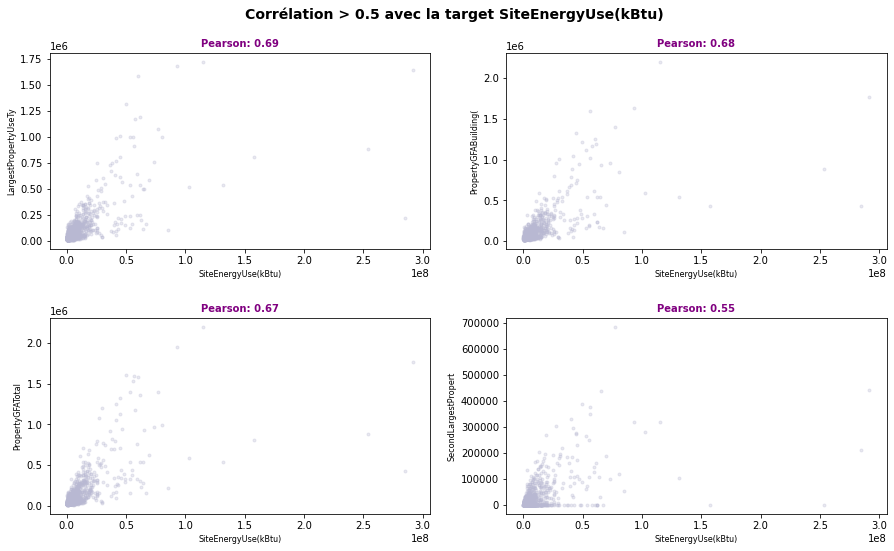

In [128]:
corr_target_EnergyUse = {'SiteEnergyUse_Largest': ['SiteEnergyUse(kBtu)', 'LargestPropertyUseTypeGFA'],
                         'SiteEnergyUse_Building': ['SiteEnergyUse(kBtu)', 'PropertyGFABuilding(s)'],
                         'SiteEnergyUse_Property': ['SiteEnergyUse(kBtu)', 'PropertyGFATotal'],
                         'SiteEnergyUse_Gas': ['SiteEnergyUse(kBtu)', 'SecondLargestPropertyUseTypeGFA']}

fig = plt.figure(figsize=(15,8))
plt.suptitle('Corrélation > 0.5 avec la target SiteEnergyUse(kBtu)', fontweight='bold', fontsize=14)
bivariate_plots_scatter(data_clean, corr_target_EnergyUse, 2, 2)

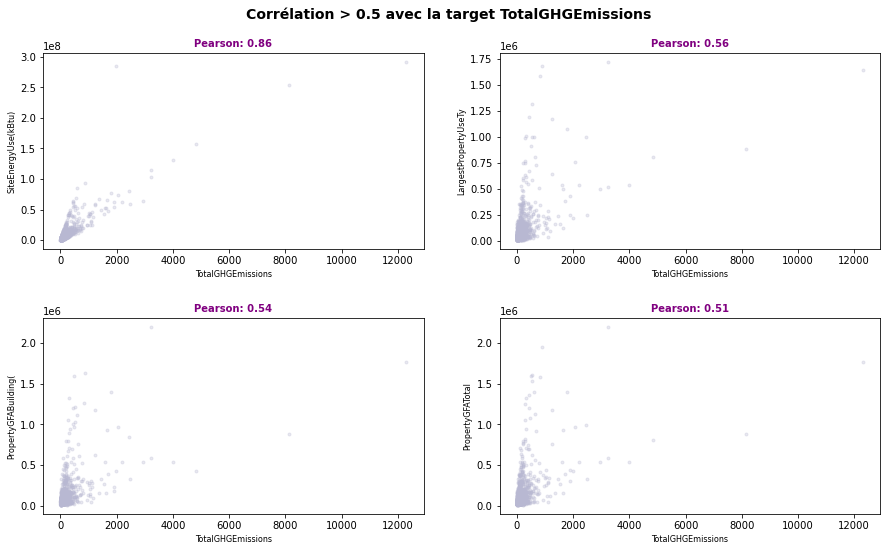

In [131]:
corr_target_GHGEmissions = {'GHGEmissions_Energy': ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'],
                            'SiteEnergyUse_Largest': ['TotalGHGEmissions', 'LargestPropertyUseTypeGFA'],
                            'SiteEnergyUse_Buildings': ['TotalGHGEmissions', 'PropertyGFABuilding(s)'],
                            'SiteEnergyUse_GFATot': ['TotalGHGEmissions', 'PropertyGFATotal']}

fig = plt.figure(figsize=(15,8))
plt.suptitle('Corrélation > 0.5 avec la target TotalGHGEmissions', fontweight='bold', fontsize=14)
bivariate_plots_scatter(data_clean, corr_target_GHGEmissions, 2, 2)

<div class="alert alert-block alert-warning">
    <p> L’"ENERGY STAR Score" n'a aucune corrélation ni positive, ni négative avec nos variables targets. De plus, elle est fastidieuse à calculer et ne sera donc pas prise en compte dans nos modèles de prédiction. </p>
</div>

In [134]:
# Liste des features corrélées aux targets
liste_feat_corr = ['LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)', 'PropertyGFATotal', 
                   'SecondLargestPropertyUseTypeGFA']

**Corrélations entre features**

In [139]:
# Dataframe avec uniquement les features corrélées aux targets
predicteurs = data_clean[liste_feat_corr]

# Matrice de corrélation pour les prédicteurs uniquement (hors target y)
corr_predicteurs = predicteurs.corr()

# Vérification de la collinéarité entre les variables "prédictrices"
df = (
     corr_predicteurs
     .stack()
     .reset_index()
     .sort_values(0, ascending=False)
)
# Zip des pairs
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index pairs
df.set_index(['pairs'], inplace=True)
# Suppression des levels
df.drop(columns=['level_1', 'level_0'], inplace=True)
# Renommage colonne en "correlation"
df.columns = ['correlation']
# Suppression des doublons avec conservation des corrélations de pairs >= 0.5
df.drop_duplicates(inplace=True)
df[(abs(df.correlation) >= 0.5) & (abs(df.correlation) != 1)]

,correlation
pairs,
"(PropertyGFABuilding(s), PropertyGFATotal)",0.98
"(LargestPropertyUseTypeGFA, PropertyGFATotal)",0.96
"(LargestPropertyUseTypeGFA, PropertyGFABuilding(s))",0.96
"(PropertyGFATotal, SecondLargestPropertyUseTypeGFA)",0.80
"(PropertyGFABuilding(s), SecondLargestPropertyUseTypeGFA)",0.76
"(LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA)",0.70


<div class="alert alert-block alert-warning">
    <p> Les variables fortement corrélées avec les targets sont également fortement corrélées entre-elles. Il faudra faire attention à ne pas les rajouter toutes dans le modèle afin de ne pas le biaiser et ajouter du poids. </p>
</div>

#### Entre une variable quantitative et une qualitative

**YearBuilt**

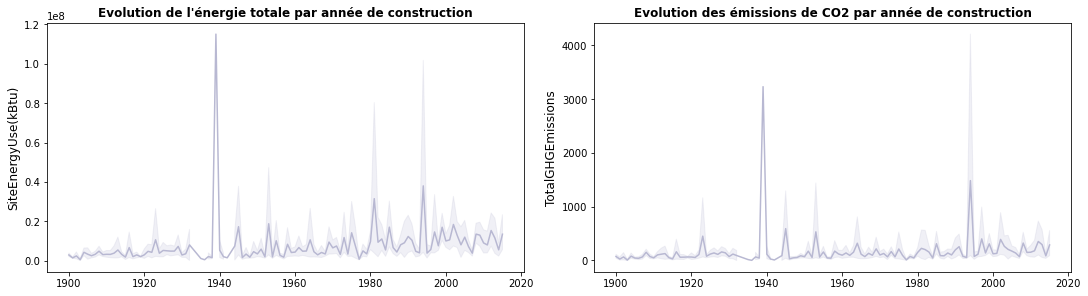

In [140]:
# Initialisation de la grille avec 1 ligne et 2 colonnes
fig = plt.figure(figsize=(15,4), constrained_layout=True)
gs = GridSpec(nrows=1, ncols=2, figure=fig)

# Premier graphique
ax1 = fig.add_subplot(gs[0,0]) # emplacement dans la grille
plt.title("Evolution de l'énergie totale par année de construction", size=12)
ax1 = sns.lineplot(data = data_clean, x = "YearBuilt", y = "SiteEnergyUse(kBtu)", color = '#b8b8d2')
plt.xlabel("", fontsize = 12)
plt.ylabel("SiteEnergyUse(kBtu)", fontsize = 12)
ax1.grid(False)
        

# Deuxième graphique
ax2 = fig.add_subplot(gs[0,1]) # emplacement dans la grille
plt.title("Evolution des émissions de CO2 par année de construction", size=12)
ax2 = sns.lineplot(data = data_clean, x = "YearBuilt", y = "TotalGHGEmissions", color = '#b8b8d2')
plt.xlabel("", fontsize = 12)
plt.ylabel("TotalGHGEmissions", fontsize = 12)
ax2.grid(False);

Les années 1940, 1980 et 1994 sont les années de construction où la consommation d'énergie est la plus importante.
Les années 1940 et 1992/1993 sont les années de construction où les émissions de CO2 sont les plus importantes.

In [143]:
Kruskal_Wallis_test(data_clean, col_target, 'YearBuilt')

Test non paramétrique de Kruskal Wallis: 

Variable SiteEnergyUse(kBtu) par YearBuilt
pvaleur: 3.97992605259027e-15 < 0.05 => on rejette H0, les médianes entre les YearBuilt sont différentes
-----------------------------------------------------------------------------------
Variable TotalGHGEmissions par YearBuilt
pvaleur: 4.5434453019797383e-07 < 0.05 => on rejette H0, les médianes entre les YearBuilt sont différentes
-----------------------------------------------------------------------------------


**BuildingType**

In [ ]:
fig = plt.figure(figsize=(15,5))
bivariate_plots_box(data_clean, 'BuildingType', col_target_log, 1, 2)

Les BuildingType de type **Campus** et **Multifamily Hr (10+)** ont une consommation d'énergie et des émissions de CO2 plus importantes que les autres types de BuildingTypes mais le BuildingType Campus a des valeurs plus dispersées que le Multifamily Hr (10+). Attention, nous avons précédemment supprimé les bâtiments non résidentiels en nous basant sur le champ PrimaryPropertyType et non pas BuildingType.

In [ ]:
Kruskal_Wallis_test(data_clean, col_target_log, 'BuildingType')

**PrimaryPropertyType**

In [ ]:
fig = plt.figure(figsize=(15,5))
bivariate_plots_box(data_clean, 'PrimaryPropertyType', col_target_log, 1, 2)

La consommation des **hôpitaux** est largement supérieure à celle des autre PrimaryPropertyTypes. Certains PrimaryPropertyTypes comme Hospital, Medical Office, College/University, Other, Retail Store ont des valeurs bien plus dispersées.

In [ ]:
Kruskal_Wallis_test(data_clean, col_target_log, 'PrimaryPropertyType')

**CouncilDistrictCode**

In [ ]:
fig = plt.figure(figsize=(15,5))
bivariate_plots_box(data_clean, 'CouncilDistrictCode', col_target_log, 1, 2)

In [ ]:
Kruskal_Wallis_test(data_clean, col_target_log, 'CouncilDistrictCode')

Les médianes sont différentes entre les différents groupes mais la visualisation ne présente pas de réelle tendance et cette variable ne sera pas utilisée par la suite

**Neighborhood**

In [ ]:
fig = plt.figure(figsize=(15,5))
bivariate_plots_box(data_clean, 'Neighborhood', col_target_log, 1, 2)

In [ ]:
Kruskal_Wallis_test(data_clean, col_target_log, 'Neighborhood')

Les médianes sont différentes entre les différents groupes mais la visualisation ne présente pas de réelle tendance et cette variable ne sera pas utilisée par la suite

**LargestPropertyUseType**

In [ ]:
fig = plt.figure(figsize=(15,8))
bivariate_plots_box(data_clean, 'LargestPropertyUseType', col_target_log, 2, 1)

In [ ]:
Kruskal_Wallis_test(data_clean, col_target_log, 'LargestPropertyUseType')

**SecondLargestPropertyUseType**

In [ ]:
fig = plt.figure(figsize=(15,8))
bivariate_plots_box(data_clean, 'SecondLargestPropertyUseType', col_target_log, 2, 1)

In [ ]:
Kruskal_Wallis_test(data_clean, col_target_log, 'SecondLargestPropertyUseType')

**ThirdLargestPropertyUseType**

In [ ]:
fig = plt.figure(figsize=(15,8))
bivariate_plots_box(data_clean, 'ThirdLargestPropertyUseType', col_target_log, 2, 1)

In [ ]:
Kruskal_Wallis_test(data_clean, col_target_log, 'ThirdLargestPropertyUseType')

**ComplianceStatus**

In [ ]:
fig = plt.figure(figsize=(10,4))
bivariate_plots_box(data_clean, 'ComplianceStatus', col_target_log, 1, 2)

In [ ]:
Kruskal_Wallis_test(data_clean, col_target_log, 'ComplianceStatus')

**Outlier**

In [ ]:
fig = plt.figure(figsize=(10,4))
bivariate_plots_box(data_clean, 'Outlier', col_target_log, 1, 2)

In [ ]:
Kruskal_Wallis_test(data_clean, col_target_log, 'Outlier')

## Modèles de prédictions <a class="anchor" id="predict"></a>

In [ ]:
data_predict = data_clean.copy()

### Modèle 1 (Baseline) - Régression linéaire
### Features: YearBuilt + BuildingType + LargestPropertyUseTypeGFA 
### Target: SiteEnergyUse(kBtu)_log

In [ ]:
# Copie du dataset
data_m1 = data_predict.copy()

#### Split en données de test et d'entrainement

In [ ]:
# Split du dataset en 80% de données d'entrainement et 20% de données de test

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_m1, test_size = 0.2,random_state = 20)

In [ ]:
print(f"Nb de lignes des données d'entrainement: {len(train_data)} \nNb de lignes des données de test: {len(test_data)}")

#### Choix des variables

In [ ]:
# Dataset avec les features et la target
train_data = train_data[['YearBuilt', 'BuildingType', 'LargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)_log']]

In [ ]:
# Split dataset des features et dataset de la target
training_input_data = train_data.drop('SiteEnergyUse(kBtu)_log', axis=1)
training_target = train_data['SiteEnergyUse(kBtu)_log']

In [ ]:
training_input_data.head(3)

In [ ]:
training_target.head(3)

#### Encodage des variables catégorielles

In [ ]:
training_input_data['BuildingType'].value_counts()

In [ ]:
# One hot encoding (car la variable catégorielle BuildingType n'est pas ordonnée)

from sklearn.preprocessing import OneHotEncoder

def one_hot(input_data):
    
    one_hot_encoder = OneHotEncoder()
    output = one_hot_encoder.fit_transform(input_data)
    output = output.toarray()

    return output

In [ ]:
categ_feat = training_input_data[['BuildingType']]
categ_feat_hot = one_hot(categ_feat)
categ_feat_hot

#### Standardisation des variables numériques

Comme notre dataset contient des outliers, nous faisons le choix de standardiser nos données c'est à dire qu'elles soient de moyenne 0 et d'écart type 1.

In [ ]:
# Standadisation des variables numériques

from sklearn.preprocessing import StandardScaler

num_feat = training_input_data[['YearBuilt', 'LargestPropertyUseTypeGFA']]

scaler = StandardScaler()

num_feat_scaled = scaler.fit_transform(num_feat)
num_feat_scaled

#### Pipeline du Data Preprocessing

In [ ]:
from sklearn.pipeline import Pipeline

StdScaler = StandardScaler()

num_feat_pipe = Pipeline([('scaler', StandardScaler())])
num_feat_preprocessed = num_feat_pipe.fit_transform(num_feat)

In [ ]:
num_feat_pipe.steps[0]

In [ ]:
OneHotEncoder()

categ_feat_pipe = Pipeline([('encoder', OneHotEncoder())])
categ_feat_preprocessed = categ_feature_pipe.fit_transform(categ_feat)

In [ ]:
categ_feat_pipe.get_feature_names_out(['BuildingType'])

#### Pipeline final du Data Preprocessing

In [ ]:
from sklearn.compose import ColumnTransformer

num_list = list(num_feat)
cat_list = list(categ_feat)

final_pipe = ColumnTransformer([('num', Pipeline([('scaler', StandardScaler())]), num_list),    
                                ('cat', categ_feat_pipe, cat_list)])

training_data_preprocessed = final_pipe.fit_transform(training_input_data)

In [ ]:
training_data_preprocessed

#### Régression linéaire sur les données d'entrainement

In [ ]:
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(training_data_preprocessed, training_target)

In [ ]:
# Coefficients (poids)
reg_model.coef_

In [ ]:
# Intercept (biais)
reg_model.intercept_

In [ ]:
final_pipe

<div class="alert alert-block alert-info">
    <p> Comment récupérer le nom des colonnes après one hot? </p>
</div>

In [ ]:
pd.DataFrame(training_input_data.columns, columns = ['Features'])

In [ ]:
pd.DataFrame(reg_model.coef_, columns = ['Coefficients'])

In [ ]:
liste_coefs_reglin = pd.concat((pd.DataFrame(training_input_data.columns), pd.DataFrame(reg_model)))

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Régression linéaire - Importance des features')
sns.barplot(y = training_input_data.columns,
            x = reg_model.coef_)

#### Evaluation du modèle

**RMSE**

In [ ]:
from sklearn.metrics import mean_squared_error

predictions = reg_model.predict(training_data_preprocessed)

In [ ]:
mse = mean_squared_error(training_target, predictions)

rmse = np.sqrt(mse)
print(f"Erreur de {rmse} kBtu (thousands of British Thermal Units) entre les données réelles et la prédiction ")

In [ ]:
train_data.describe()['SiteEnergyUse(kBtu)_log']['mean']

**Cross validation**

In [ ]:
# Scorers pouvant être utilisés

from sklearn import metrics
metrics.SCORERS.keys()

In [ ]:
from sklearn.model_selection import cross_val_score

scoring = 'neg_root_mean_squared_error' 
scores = cross_val_score(reg_model, training_data_preprocessed, training_target, scoring = scoring, cv=10)

In [ ]:
scores = -scores
scores.mean()

In [ ]:
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(reg_model, training_data_preprocessed, training_target, cv=10)

In [ ]:
mse_cross_val = mean_squared_error(training_target, predictions)
rmse_cross_val = np.sqrt(mse_cross_val)
rmse_cross_val 

**Evaluation sur les données de test**

In [ ]:
# Dataset avec les features et la target
test_data = test_data[['YearBuilt', 'BuildingType', 'LargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)_log']]

In [ ]:
test_input_data = test_data.drop('SiteEnergyUse(kBtu)_log', axis=1)
test_target = test_data['SiteEnergyUse(kBtu)_log']

test_preprocessed = final_pipe.transform(test_input_data)

In [ ]:
test_pred = reg_model.predict(test_preprocessed)
test_mse = mean_squared_error(test_target,test_pred)

test_rmse = np.sqrt(test_mse)
test_rmse

L'évaluation du modèle sur les données d'entrainement à l'aide de la validation croisée nous donne un rmse de 1.03 log et 1.07 kBtu sur les données de test.

### Comparaison des modèles

In [ ]:
# Création d'un dataframe avec les indicateurs principaux de nos 3 modèles
data_results = [['Model 1', rsq_adj_m1, rmse_m1, mae_m1], ['Model 2', rsq_adj_m2, rmse_m2, mae_m2], ['Model 3', rsq_adj_m3, rmse_m3, mae_m3]] 
model_results = pd.DataFrame(data_results, columns = ['Model', 'Adj R-Squared', 'Root Mean Square Error', 'Mean Absolute Error']) 
model_results

In [ ]:
# Création d'un barplot montrant la performance sur la MAE et de l'Adjusted r^2
fig, ax1 = plt.subplots(figsize=(12,6))
sns.set_style("whitegrid")

sns.barplot(data = model_results, x='Model', y='Mean Absolute Error',  palette="Blues_d", ax=ax1)
ax1.set_title('Linear Regression Model Performance', fontweight="bold", fontsize=14)
ax1.yaxis.label.set_color('tab:blue')
ax1.tick_params(axis='y', colors='tab:blue')
ax2 = ax1.twinx()
sns.lineplot(data = model_results['Adj R-Squared'], marker='o', sort = False, color='tab:orange', linewidth=4, ax=ax2)
ax2.set(ylim=(0, 1))
ax2.yaxis.label.set_color('tab:orange')
ax2.tick_params(axis='y', colors='tab:orange')
ax2.grid(None)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    <p> Pas pris les variables provenant d'un relevé, OK? </p>
</div>

## Feature engineering <a class="anchor" id="features"></a>

Nous pouvons déduire de nouvelles variables à partir des données existantes dans le dataset. Ce procédé s'appelle le feature engineering. Il s'agit de créer de nouvelles variables qui seront utilisées en apprentissage supervisé. En effet, pour que les algorithmes de Machine Learning fonctionnent bien sur de nouvelles données, il peut être nécessaire de créer et entrainer de nouvelles variables. Voici une sélection de variables qui peuvent être créées grâce à nos données:

- **décennie de construction**
- **moyenne de la superficie par étage** en intervalles
- **superficie totale du bâtiment** en intervalles
- **part du parking dans la surface totale**
- **part de l'utilisation principale, secondaire et tertiaire dans la surface totale**
- si le bâtiment a été **certifié par ENERGYSTAR** sur les années 2015, 2016 et / ou 2017
- **part de chaque type d'énergie utilisée** (attention data leakage) avec 3 modalités: 'Mainly Steam' / 'Mainly Electricity' / 'Mainly Gas'

### Decennie de construction

In [ ]:
def todecade(col_year):  
    return str(col_year)[0:3] + '0'

In [ ]:
data_clean['Decade'] = data_clean['YearBuilt'].apply(todecade)
data_clean['Decade'] = data_clean['Decade'].astype(int)
data_clean['Decade'].unique()

In [ ]:
sns.catplot(x = "Decade", kind = "count", data = data_clean, palette='Purples_r', height=4, aspect=15/8)
plt.title('Nombre de bâtiments par décennie');

### Superficie moyenne par étage (intervalles)

<div class="alert alert-block alert-info">
    <p> doit on créer des bins? si oui qcut ou cut? et combien de bins?</p>
</div>

In [ ]:
# (+1 pour comptabiliser le rez de chaussée)
data_clean['AvgGFAFloor'] = round(data_clean['PropertyGFABuilding(s)']/(data_clean['NumberofFloors']+1),0).apply(ceil)

In [ ]:
data_clean['AvgGFAFloor'].describe()

In [ ]:
plt.figure(figsize=(15,5))
data_clean['AvgGFAFloor'].hist(bins = 100, color = '#b8b8d2', ec = 'k')
plt.grid(False)
plt.title('Histogramme de la variable AvgGFAFloor', fontsize=10)
plt.ticklabel_format(useOffset=False, style='plain');

In [ ]:
# Découpage en 5 quantiles égaux: 
data_clean['AvgGFAFloorBins'] = pd.qcut(data_clean['AvgGFAFloor'], 5)
data_clean['AvgGFAFloorBins'].value_counts()

### Superficie totale du bâtiment (intervalles)

In [ ]:
data_clean['PropertyGFABuilding(s)'].describe()

In [ ]:
plt.figure(figsize=(15,5))
data_clean['PropertyGFABuilding(s)'].hist(bins = 100, color = '#b8b8d2', ec = 'k')
plt.grid(False)
plt.title('Histogramme de la variable PropertyGFABuilding(s)', fontsize=10)
plt.ticklabel_format(useOffset=False, style='plain');

In [ ]:
# Découpage en 5 quantiles égaux: 
data_clean['GFABuildingsBins'] = pd.qcut(data_clean['PropertyGFABuilding(s)'], 5)
data_clean['GFABuildingsBins'].value_counts()

### Part du parking dans la surface totale (intervalle)

In [ ]:
data_clean['GFAParking%'] = ((data_clean['PropertyGFAParking']/data_clean['PropertyGFATotal'])*100).apply(ceil)

In [ ]:
plt.figure(figsize=(15,5))
data_clean['GFAParking%'].hist(bins = 100, color = '#b8b8d2', ec = 'k')
plt.grid(False)
plt.title('Histogramme de la variable GFAParking%', fontsize=10)
plt.ticklabel_format(useOffset=False, style='plain');

In [ ]:
# Découpage en 5 quantiles égaux: 
data_clean['GFAParking%Bins'] = pd.qcut(data_clean['GFAParking%'], 5)
data_clean['GFAParking%Bins'].value_counts()

### Part de l'utilisation principale, secondaire et tertiaire dans la surface totale

In [ ]:
# Utilisation principale
data_clean['LargestPropertyUseTypeGFA%'] = ((data_clean['LargestPropertyUseTypeGFA']/data_clean['PropertyGFATotal'])*100).apply(ceil)

In [ ]:
data_clean['LargestPropertyUseTypeGFA%'].describe()

In [ ]:
plt.figure(figsize=(15,5))
data_clean['LargestPropertyUseTypeGFA%'].hist(bins = 100, color = '#b8b8d2', ec = 'k')
plt.grid(False)
plt.title('Histogramme de la variable LargestPropertyUseTypeGFA%', fontsize=10)
plt.ticklabel_format(useOffset=False, style='plain');

<div class="alert alert-block alert-info">
    <p> on supprime ces lignes?, on fait pareil pour second et third ou on s'arrête à largest?</p>
</div>

In [ ]:
# Si % supérieur à 100%, on le ramène à 100%
print(f"Part la plus importante de la propriété > 100% du total: {data_clean[data_clean['LargestPropertyUseTypeGFA%'] > 100].shape[0]} lignes")

In [ ]:
data_clean[data_clean['LargestPropertyUseTypeGFA%'] > 100]

### Certification EnergyStar sur 2015, 2016 et/ou 2017

In [79]:
data_clean['YearsENERGYSTARCertified']

0       ()
2       ()
4       ()
7       ()
8       ()
        ..
6711    ()
6712    ()
6713    ()
6714    ()
6715    ()
Name: YearsENERGYSTARCertified, Length: 1483, dtype: object

In [ ]:
import re

In [78]:
data_clean['YearsENERGYSTARCertified'] = data_clean['YearsENERGYSTARCertified'].replace('\W','',regex=True).astype(object)

In [74]:
data_clean[(data_clean['ThirdLargestPropertyUseType'].str.contains(r'Medical|Office'))]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,ComplianceStatus,Outlier,MainEnergyUsed,SiteEnergyUse(kBtu),TotalGHGEmissions
37,24,2016,Nonresidential,Mixed Use Property,7,Downtown,1907,1.00,5.00,57452,0,57452,"Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall",Social/Meeting Hall,"16,442.00",Restaurant,"15,505.00",Office,"9,741.00",(),NaN,Compliant,Not an Outlier,Electricity,"7,606,084.50",273.02
71,46,2016,Nonresidential,Warehouse,2,Greater Duwamish,1961,3.00,2.00,714095,0,714095,"Non-Refrigerated Warehouse, Office, Refrigerated Warehouse",Non-Refrigerated Warehouse,"616,000.00",Refrigerated Warehouse,"276,000.00",Office,"71,000.00",(),NaN,Compliant,Not an Outlier,Electricity,"44,731,160.00",311.84
84,55,2016,Nonresidential,Self-Storage Facility,7,Downtown,1911,1.00,3.00,70586,0,70586,"Office, Self-Storage Facility, Vocational School",Self-Storage Facility,"38,439.00",Vocational School,"28,197.00",Office,"3,859.00",(),NaN,Compliant,Not an Outlier,Electricity,"2,158,629.00",45.43
93,60,2016,Nonresidential,Mixed Use Property,7,Downtown,1926,1.00,2.00,52549,0,52549,"Office, Other - Entertainment/Public Assembly, Restaurant",Other - Entertainment/Public Assembly,"23,500.00",Restaurant,"23,500.00",Office,"5,459.00",(),NaN,Compliant,Not an Outlier,Gas,"15,026,196.00",584.31
131,96,2015,Nonresidential,Mixed Use Property,3,East,1983,1.00,6.00,187600,18493,169107,"Data Center, Medical Office, Non-Refrigerated Warehouse, Office, Other, Parking",Medical Office,"40,174.00",Parking,"20,868.00",Office,"17,020.00",(),NaN,Compliant,Not an Outlier,Electricity,"15,240,688.00",444.42
248,200,2016,Nonresidential,Other,5,Northwest,1996,1.00,3.00,55442,0,55442,"Financial Office, Medical Office, Parking",Financial Office,"28,636.00",Parking,"15,385.00",Medical Office,"8,644.00",(),72.00,Compliant,Not an Outlier,Electricity,"3,191,228.25",83.70
291,234,2015,Nonresidential Cos,Non-Refrigerated Warehouse,7,Magnolia / Queen Anne,1926,1.00,2.00,50292,0,50292,"Non-Refrigerated Warehouse, Office, Other - Services, Residence Hall/Dormitory",Non-Refrigerated Warehouse,"42,345.00",Residence Hall/Dormitory,"5,000.00",Office,"4,730.00",(),NaN,Compliant,Not an Outlier,Electricity,"715,446.00",4.99
313,248,2015,Nonresidential Cos,Non-Refrigerated Warehouse,2,Greater Duwamish,1965,1.00,2.00,50000,0,50000,"Non-Refrigerated Warehouse, Office, Other, Other - Services",Non-Refrigerated Warehouse,"40,831.00",Other - Services,"16,735.00",Office,"11,533.00",(),NaN,Compliant,Not an Outlier,Electricity,"4,116,805.00",28.70
324,263,2015,Nonresidential,Other,5,North,2008,1.00,6.00,419848,335109,84739,"Fast Food Restaurant, Medical Office, Movie Theater, Parking, Retail Store",Parking,"335,109.00",Movie Theater,"65,000.00",Medical Office,"13,567.00",(),NaN,Compliant,Not an Outlier,Electricity,"9,477,865.00",163.99
369,293,2016,Nonresidential,Other,7,Downtown,1914,1.00,7.00,128766,0,128766,"Office, Other, Other - Entertainment/Public Assembly",Other - Entertainment/Public Assembly,"109,754.00",Other,"12,876.00",Office,"6,136.00",(),NaN,Compliant,Not an Outlier,Electricity,"6,057,410.00",57.21


In [71]:
data_clean[data_clean['YearsENERGYSTARCertified'].str.contains(2015)]

TypeError: first argument must be string or compiled pattern

<div class="alert alert-block alert-info">
    <p> Comment vérifier si une valeur est dans la colonne?</p>
</div>

In [ ]:
annee_certif_recente = ['2015', '2016', '2017']

if '2015' in data_clean['YearsENERGYSTARCertified'].values :
    print("\nThis value exists in Dataframe")

In [ ]:
np.where(data_clean['YearsENERGYSTARCertified'].isnull(), 
                                     df[f'{var_to_map}_y'], 
                                     df[f'{var_to_map}_x'])

[Retour à la table des matières](#0)